<a href="https://colab.research.google.com/github/JaperTai77/Tensorflow_DL/blob/main/tf2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning (Feature Extraction)

### Import data

In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-05 04:52:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  44.7MB/s    in 3.6s    

2021-11-05 04:52:51 (44.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



#### Test data

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/test"):
  print(f"There are {len(filenames)} images in {dirpath}")

There are 0 images in 10_food_classes_10_percent/test
There are 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 250 images in 10_food_classes_10_percent/test/sushi
There are 250 images in 10_food_classes_10_percent/test/pizza
There are 250 images in 10_food_classes_10_percent/test/hamburger
There are 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 250 images in 10_food_classes_10_percent/test/fried_rice
There are 250 images in 10_food_classes_10_percent/test/ice_cream
There are 250 images in 10_food_classes_10_percent/test/ramen
There are 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 250 images in 10_food_classes_10_percent/test/steak


#### Train data

In [ ]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/train"):
  print(f"There are {len(filenames)} images in {dirpath}")

There are 0 images in 10_food_classes_10_percent/train
There are 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 75 images in 10_food_classes_10_percent/train/sushi
There are 75 images in 10_food_classes_10_percent/train/pizza
There are 75 images in 10_food_classes_10_percent/train/hamburger
There are 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 75 images in 10_food_classes_10_percent/train/fried_rice
There are 75 images in 10_food_classes_10_percent/train/ice_cream
There are 75 images in 10_food_classes_10_percent/train/ramen
There are 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 75 images in 10_food_classes_10_percent/train/steak


#### Import train/test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train = train_datagen.flow_from_directory(train_dir,
                                     target_size = (224,224),
                                     batch_size = 32,
                                     class_mode = 'categorical')
test = test_datagen.flow_from_directory(test_dir,
                                     target_size = (224,224),
                                     batch_size = 32,
                                     class_mode = 'categorical')                           

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Feature extraction

#### Tensorboard Callback

In [ ]:
import datetime
import tensorflow as tf

def tensorboard_call(dir_name,experiment_name):
  log_dir = dir_name+ "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return callback

https://tfhub.dev

In [ ]:
import tensorflow_hub as hub
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

Compare efficient net and resnet

In [ ]:
def create_model(model_url, classes = 10):
  # from example usage of the model
  # download pretrained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                     trainable = False, # freeze learned pattern
                                     name = 'feature_extraction_layer',
                                     input_shape = (224,224,3))
  # create model
  model = tf.keras.Sequential([
              feature_extractor_layer,
              tf.keras.layers.Dense(classes,activation = 'softmax', name = 'output_layer')
  ])

  return model

#### Resnet

In [ ]:
resnet = create_model(resnet_url,classes = 10)
resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
resnet.fit(train,epochs = 5, steps_per_epoch = len(train),
           validation_data = test, validation_steps = len(test),
           callbacks = [tensorboard_call('tensorflow_hub','resnet')])

Saving TensorBoard log files to: tensorflow_hub/resnet/20211103-073425
Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 1.9626 - accuracy: 0.3413 - val_loss: 1.1941 - val_accuracy: 0.6280
Epoch 2/5
24/24 [==============================] - 22s 923ms/step - loss: 0.8961 - accuracy: 0.7453 - val_loss: 0.8509 - val_accuracy: 0.7324
Epoch 3/5
24/24 [==============================] - 21s 916ms/step - loss: 0.6249 - accuracy: 0.8240 - val_loss: 0.7682 - val_accuracy: 0.7476
Epoch 4/5
24/24 [==============================] - 21s 916ms/step - loss: 0.4780 - accuracy: 0.8707 - val_loss: 0.7418 - val_accuracy: 0.7524
Epoch 5/5
24/24 [==============================] - 21s 910ms/step - loss: 0.3795 - accuracy: 0.9093 - val_loss: 0.6846 - val_accuracy: 0.7756


#### Efficient Net

In [ ]:
effnet = create_model(efficientnet_url,classes = 10)
effnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
effnet.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
effnet.fit(train, epochs = 5, steps_per_epoch = len(train),
           validation_data = test,validation_steps = len(test),
           callbacks = [tensorboard_call('tensorflow_hub','efficientNet')])

Saving TensorBoard log files to: tensorflow_hub/efficientNet/20211103-073706
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8407 - accuracy: 0.4307 - val_loss: 1.2971 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 19s 815ms/step - loss: 1.0443 - accuracy: 0.7733 - val_loss: 0.8693 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 19s 816ms/step - loss: 0.7422 - accuracy: 0.8453 - val_loss: 0.6993 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 19s 810ms/step - loss: 0.5925 - accuracy: 0.8720 - val_loss: 0.6135 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 19s 809ms/step - loss: 0.5003 - accuracy: 0.8960 - val_loss: 0.5602 - val_accuracy: 0.8624


#### Compare in tensor board

results and data become public

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNet vs. ResNet" \
  --description "Comparing the two models" \
  --one_shot

In [ ]:
!tensorboard dev list

In [ ]:
# delete experiment 
!tensorboard dev delete --experiment_id FnFb6OdRRPOT

# Transfer Learning (Fine Tunning)

## Create model (functional API)

#### Import data

function that is often used are stored

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-11-04 06:28:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-04 06:28:05 (80.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-04 06:28:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   171MB/s    in 0.9s    

2021-11-04 06:28:06 (171 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import tensorflow as tf
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_10_percent/train/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_10_percent/test/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for image, label in train.take(1):
  print('Batch size:',len(image))
  print(label)

Batch size: 32
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 

#### Model 1

-10% training data\
-no preprocess\
-efficientnet with all layer frozen

In [ ]:
import tensorflow as tf
model_base = tf.keras.applications.EfficientNetB0(include_top = False) # want to train top layers

# freeze base model (pre-trained patterns aren't trained)
model_base.trainable = False

input = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')

# need to rescale for some application (effnet not require)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = model_base(input)
print(x.shape)
# aggregate all the most important information, reduce number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_pooling_layer')(x)
print(x.shape)

output = tf.keras.layers.Dense(10,activation = 'softmax', name = 'output_layer')(x)
model_1 = tf.keras.Model(input, output)

(None, 7, 7, 1280)
(None, 1280)


In [ ]:
import datetime
log_dir = 'transfer_learning/model1/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])
history1 = model_1.fit(train,
                     epochs = 5,
                     steps_per_epoch = len(train),
                     validation_data = test,
                     validation_steps = int(0.25*len(test)),
                     callbacks = [tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 90s 3s/step - loss: 1.8864 - accuracy: 0.4013 - val_loss: 1.3470 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 81s 3s/step - loss: 1.1314 - accuracy: 0.7640 - val_loss: 0.9304 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 81s 3s/step - loss: 0.8297 - accuracy: 0.8107 - val_loss: 0.7704 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 82s 3s/step - loss: 0.6868 - accuracy: 0.8427 - val_loss: 0.6747 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 82s 3s/step - loss: 0.5791 - accuracy: 0.8667 - val_loss: 0.6273 - val_accuracy: 0.8372


In [ ]:
for layer_number, layer in enumerate(model_base.layers):
  if int(layer_number)<10:
    print(layer_number, layer.name)

# or model_base.summary()

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_pooling_layer (Global (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


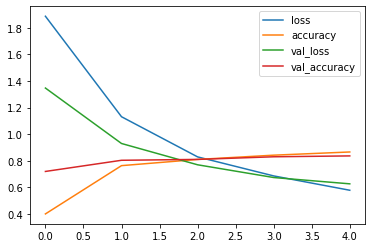

In [ ]:
import pandas as pd
pd.DataFrame(history1.history).plot()

**EVALUATION**

In [ ]:
model_1.evaluate(test)

79/79 [==============================] - 138s 2s/step - loss: 0.6047 - accuracy: 0.8404


[0.6047024726867676, 0.840399980545044]

#### Demonstrate global average pooling 2D

Transform a 4d tensor to 2d using average pooling

In [ ]:
input_shape = (1,4,4,3)
input_tensor = tf.random.normal(input_shape)
print(f'Input tensor:\n {input_tensor}')

global_average_pool_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'Output tensor: {global_average_pool_tensor}')

print(global_average_pool_tensor.shape)

Input tensor:
 [[[[-1.10230970e+00 -7.21740872e-02 -2.86837339e+00]
   [ 2.11930823e+00 -1.50148362e-01  6.01058602e-01]
   [-1.26361716e+00  1.25238836e-01  4.72676128e-01]
   [-8.01038325e-01  2.36788064e-01  7.46527672e-01]]

  [[ 1.15486789e+00  1.10739999e-01 -2.34664202e-01]
   [-5.49838305e-01  3.49650264e-01  4.36587840e-01]
   [-1.58540711e-01 -1.22204018e+00 -4.91354644e-01]
   [ 1.17571306e+00  1.00407265e-01 -1.00859952e+00]]

  [[ 7.87669122e-01  1.73916459e-01  1.22240293e+00]
   [-2.00681019e+00 -2.57639855e-01  2.50941515e-01]
   [-5.72830021e-01  6.55921698e-02  4.48943198e-01]
   [ 1.94852781e+00  1.12261140e+00 -1.02592245e-01]]

  [[ 1.31966993e-01  2.13519764e+00 -5.28527439e-01]
   [ 1.65329814e+00 -1.40667439e+00  5.78902483e-01]
   [-1.19949520e+00  1.24162829e+00  3.10089678e-01]
   [ 6.39417791e-04 -1.04483776e-02  1.97003275e-01]]]]
Output tensor: [[0.08234445 0.15891531 0.00193886]]
(1, 3)


In [ ]:
# Alternative
tf.reduce_mean(input_tensor, axis=[1, 2]).numpy() == global_average_pool_tensor.numpy()

array([[ True,  True,  True]])

Condense information and extract feature

## Series of Transfer Learning 

#### Import data 

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-05 04:52:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.15.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  64.0MB/s    in 2.0s    

2021-11-05 04:52:02 (64.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [2]:
import tensorflow as tf
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_1_percent/train/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_1_percent/test/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Model 2

-1% training data\
-data augmentation\
-efficientnet with all layer frozen

Data Augmentation

In [ ]:
# process happens on the GPU (if using) and only happens in training
Augmentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
            tf.keras.layers.experimental.preprocessing.RandomHeight(0.2)
            # tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
            ],name = 'data_augmentation')

Visualize image

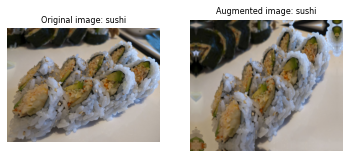

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class 
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image 
img = mpimg.imread(random_image_path)
plt.subplot(1,2,1)
plt.imshow(img) 
plt.title(f"Original image: {target_class}", fontsize = 8)
plt.axis(False);

augmented_img = Augmentation(tf.expand_dims(img, axis=0)) # data augmentation requires shape (None, height, width, 3)
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(tf.cast(augmented_img, dtype = tf.float32))/255.) # requires normalization after augmentation
plt.title(f"Augmented image: {target_class}",fontsize = 8)
plt.axis(False);

Build model

In [ ]:
model_base = tf.keras.applications.EfficientNetB0(include_top = False)
model_base.trainable = False

input = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')
# Add augmentation layer to model1
x = Augmentation(input)
x = model_base(x,training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
output = tf.keras.layers.Dense(10,activation = 'softmax', name = 'output_layer')(x)
model_2 = tf.keras.Model(input,output)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history2 = model_2.fit(train, steps_per_epoch = len(train), epochs = 5,
                       validation_data = test, validation_steps = int(0.25*len(test))
                       )

Epoch 1/5
3/3 [==============================] - 47s 19s/step - loss: 2.3434 - accuracy: 0.1714 - val_loss: 2.1600 - val_accuracy: 0.2385
Epoch 2/5
3/3 [==============================] - 38s 18s/step - loss: 2.0593 - accuracy: 0.3143 - val_loss: 2.0524 - val_accuracy: 0.2911
Epoch 3/5
3/3 [==============================] - 38s 18s/step - loss: 1.8606 - accuracy: 0.5286 - val_loss: 1.9576 - val_accuracy: 0.3454
Epoch 4/5
3/3 [==============================] - 39s 18s/step - loss: 1.7427 - accuracy: 0.5429 - val_loss: 1.8924 - val_accuracy: 0.3914
Epoch 5/5
3/3 [==============================] - 38s 18s/step - loss: 1.6014 - accuracy: 0.6286 - val_loss: 1.7935 - val_accuracy: 0.4556


In [ ]:
pd.DataFrame(history2.history).plot()

**EVALUATION**

In [ ]:
model_2.evaluate(test)

79/79 [==============================] - 141s 2s/step - loss: 1.7952 - accuracy: 0.4484


[1.7951689958572388, 0.44839999079704285]

#### Model 3 (model check point)

-10% training data\
-data augmentation\
-efficientnet all layer frozen

In [3]:
import tensorflow as tf
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_10_percent/train/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_10_percent/test/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32,
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
Augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
      tf.keras.layers.experimental.preprocessing.RandomHeight(0.1),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
      #tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
      ])


model_base = tf.keras.applications.EfficientNetB0(include_top=False)
model_base.trainable = False # layers in our model not trainable

input = tf.keras.layers.Input(shape = (224,224,3))
x = Augmentation(input)
x = model_base(x,training=False) # keep base model in inference mode (no change) and batchnorm layer doesn't update
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(10, activation = tf.keras.activations.softmax)(x)
model_3 = tf.keras.Model(input, output)

model_3.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])


16719872/16705208 [==============================] - 0s 0us/step


Model Checkpoint

In [5]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
# save weights only (faster than saving all)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = False,
                                                save_freq = 'epoch',
                                                verbose = 1)

In [6]:
import datetime
log_dir = 'transfer_learning/model3/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

history3_1 = model_3.fit(train,epochs=5, steps_per_epoch=len(train),
                         validation_data=test,validation_steps=int(0.25 * len(test)),
                         callbacks=[checkpoint,tensorboard])

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 55s 840ms/step - loss: 1.9248 - accuracy: 0.3800 - val_loss: 1.3928 - val_accuracy: 0.6562

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 14s 588ms/step - loss: 1.2775 - accuracy: 0.6853 - val_loss: 0.9950 - val_accuracy: 0.7697

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 12s 498ms/step - loss: 0.9727 - accuracy: 0.7627 - val_loss: 0.8187 - val_accuracy: 0.8224

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 14s 597ms/step - loss: 0.8234 - accuracy: 0.7947 - val_loss: 0.7077 - val_accuracy: 0.8339

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 15s 618ms/step - loss: 0.7240 - accuracy: 0.8

**EVALUATION**

In [ ]:
model_3.evaluate(test)

79/79 [==============================] - 138s 2s/step - loss: 0.6684 - accuracy: 0.8252


[0.6684066653251648, 0.8252000212669373]

Load checkpoint weight

In [ ]:
print(checkpoint_path)

ten_percent_model_checkpoints_weights/checkpoint.ckpt


In [29]:
model_3.load_weights(checkpoint_path)

In [23]:
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
for layer in model_3.layers:
  print(layer.trainable)

True
True
False
True
True


## Fine Tunning

#### View trainable

In [9]:
for layer in model_3.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4dffdc98d0> True
<keras.engine.sequential.Sequential object at 0x7f4dff1d11d0> True
<keras.engine.functional.Functional object at 0x7f4df0129590> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f4df010c1d0> True
<keras.layers.core.Dense object at 0x7f4df005d510> True


third layer is untrainable, so inspect the thrid layer

In [15]:
# third layer
for number, layer in enumerate(model_3.layers[2].layers):
  if number<20:
    print(number, layer.name, layer.trainable)
print('And so on')

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
And so on


In [18]:
print(len(model_3.layers[2].trainable_variables))

0


#### Model 4

-10% training data\
-data augmentation\
-efficientnet top layer frozen bottom will train

In [ ]:
import tensorflow as tf
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_10_percent/train/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "10_food_classes_10_percent/test/",
    image_size = (224,224),
    label_mode = 'categorical',
    batch_size = 32,
)

In [38]:
model_base = tf.keras.applications.EfficientNetB0(include_top=False)
model_base.trainable = True
# freeze layers except last 10
for layer in model_base.layers[:-10]:
  layer.trainable = False

input = tf.keras.layers.Input(shape = (224,224,3))
x = Augmentation(input)
x = model_base(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(10, activation = tf.keras.activations.softmax)(x)
model_4 = tf.keras.Model(input, output)
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

model_4.load_weights(checkpoint_path)

print(len(model_4.trainable_variables))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


12


In [34]:
history_4 = model_4.fit(train,epochs=10,validation_data=test,
                        steps_per_epoch = len(train),
                        initial_epoch=history3_1.epoch[-1], # previous last epoch
                        validation_steps=int(0.25 * len(test)),
                        )

Epoch 5/10
24/24 [==============================] - 21s 567ms/step - loss: 0.8078 - accuracy: 0.7400 - val_loss: 0.4893 - val_accuracy: 0.8372
Epoch 6/10
24/24 [==============================] - 11s 462ms/step - loss: 0.3241 - accuracy: 0.8947 - val_loss: 0.4224 - val_accuracy: 0.8586
Epoch 7/10
24/24 [==============================] - 12s 474ms/step - loss: 0.1387 - accuracy: 0.9560 - val_loss: 0.5016 - val_accuracy: 0.8289
Epoch 8/10
24/24 [==============================] - 12s 470ms/step - loss: 0.0858 - accuracy: 0.9720 - val_loss: 0.5442 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0877 - accuracy: 0.9720 - val_loss: 0.5552 - val_accuracy: 0.8405
Epoch 10/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0374 - accuracy: 0.9933 - val_loss: 0.5210 - val_accuracy: 0.8454


In [40]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                12810     
Total params: 4,062,381
Trainable params: 906,042
Non-trainable params: 3,156,339
_________________________________________________________________


In [41]:
model_4.evaluate(test)

79/79 [==============================] - 14s 136ms/step - loss: 0.6524 - accuracy: 0.8368


[0.6523900032043457, 0.8367999792098999]

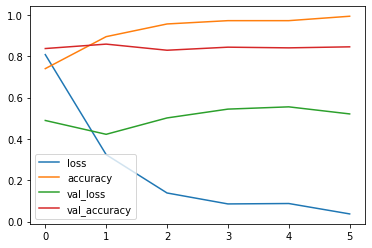

In [43]:
import pandas as pd
pd.DataFrame(history_4.history).plot()